In [61]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
import os
import pickle

from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet

from sklearn.metrics import mean_squared_error, r2_score

Source of knowledge: https://towardsdatascience.com/the-complete-guide-to-time-series-forecasting-using-sklearn-pandas-and-numpy-7694c90e45c1

In [62]:
%run Modeling_Utils.ipynb

## Load Data

In [63]:
load_data = LoadData()
PM_data = load_data.load_PM_data()
Rain_data = load_data.load_Rain_data()

## Pre-processing

In [64]:
# Start with rain data
rain_TS = pd.concat([value.set_index('Date') for value in Rain_data.copy().values()], axis=0).fillna(0).rename(columns={'73T':'Rain_73T'})
rain_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot:xlabel='Date'>

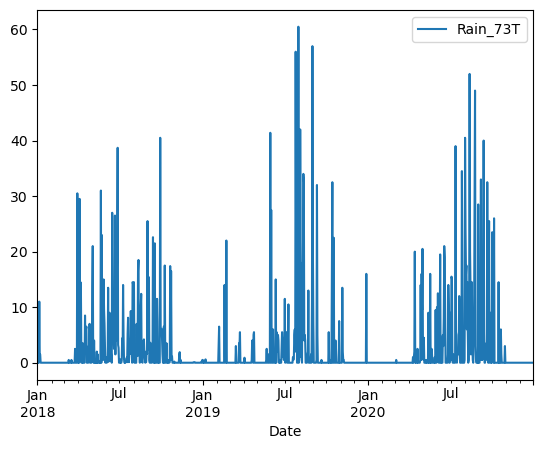

In [65]:
rain_TS.plot()

In [66]:
scope_year = [2018, 2019, 2020]
PM_TS = station_data_TS(PM_data, '73T', scope_year=scope_year)
PM_TS.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1092 entries, 2018-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM_73T  1092 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


<AxesSubplot:xlabel='Date'>

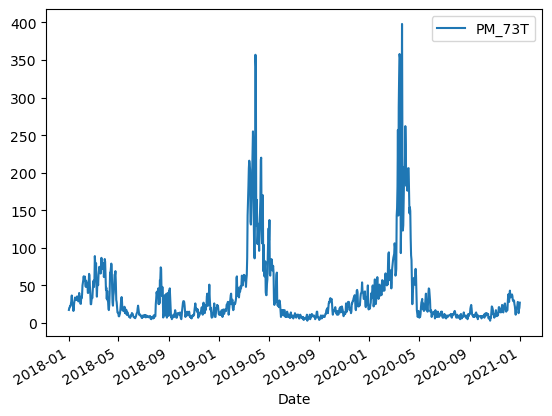

In [67]:
PM_TS.plot()

In [68]:
Data = pd.concat([rain_TS, PM_TS], axis=1)
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1092 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


In [69]:
Data[Data['PM_73T'].isna()]

,Rain_73T,PM_73T
Date,,
2018-06-29,2.7,NaN
2019-06-29,0.5,NaN
2020-02-29,0.0,NaN
2020-06-29,0.0,NaN


<AxesSubplot:xlabel='Date'>

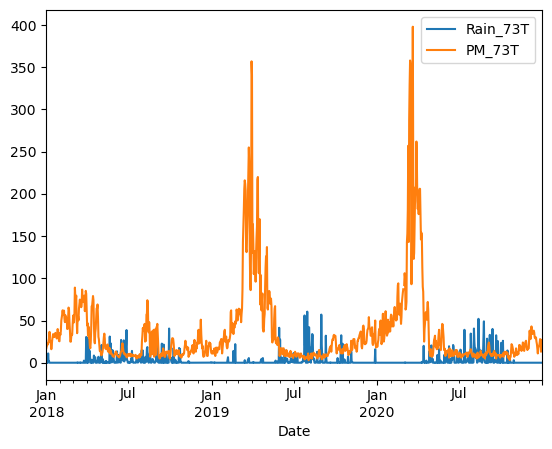

In [70]:
Data.plot()

In [71]:
# Fill nan on PM
Data['PM_73T'] = Data['PM_73T'].interpolate('linear')
Data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2018-01-01 to 2020-12-31
Freq: D
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Rain_73T  1096 non-null   float64
 1   PM_73T    1096 non-null   float64
dtypes: float64(2)
memory usage: 25.7 KB


<AxesSubplot:xlabel='Date'>

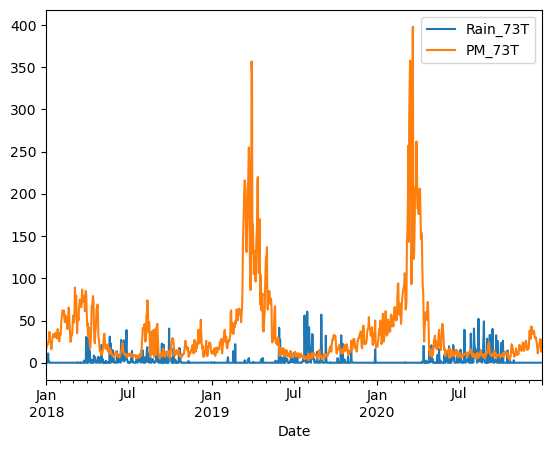

In [72]:
Data.plot()

In [73]:
Data['Date_num'] = np.arange(Data.shape[0])
Data

,Rain_73T,PM_73T,Date_num
Date,,,
2018-01-01,7.5,17.333333,0
2018-01-02,0.0,20.222222,1
2018-01-03,5.5,20.555556,2
2018-01-04,0.0,22.555556,3
2018-01-05,11.0,22.444444,4
...,...,...,...
2020-12-27,0.0,27.000000,1091
2020-12-28,0.0,13.000000,1092
2020-12-29,0.0,18.000000,1093


## Modelling

Model
- Regression
- Gradient Boosting
- K-NN

### Univariate with rain

In [74]:
def univariate_piplines(window_length, data, column_name, target_name, portion, model):
    # preparing data
    new_data, add_columns = window_input(window_length, data.copy(), column_name)
    X, y = new_data.copy()[add_columns].to_numpy(), new_data.copy()[target_name].to_numpy()
    dim = len(add_columns)
    minmax_model = MinMaxScaler().fit(X)
    X = minmax_model.transform(X)
    X_train, X_test = X[:int(X.shape[0] * portion)].reshape(-1, dim), X[int(X.shape[0] * portion):].reshape(-1, dim)
    y_train, y_test = y[:int(y.shape[0] * portion)].reshape(-1, 1), y[int(y.shape[0] * portion):].reshape(-1, 1)

    # train model
    trained_model = model.fit(X_train, y_train.ravel())
    return trained_model, minmax_model, X_test, y_test.ravel()


In [75]:
# Configuration
window_length = 3
data = Data.copy()
column_name = 'Rain_73T'
target_name = 'PM_73T'
portion = 0.8
next_timestep = [2, 5, 7, 10, 15]
model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}

In [76]:
various_timestep = {}
test_dict = {}
for window_length in next_timestep:
    trained_model_dict = {}
    model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}
    for model_name, model in model_dict.items():
        print(f'{model_name} at {window_length} window length')
        trained_model, minmax_model, X_test, y_test = univariate_piplines(window_length, data, column_name, target_name, portion, model)
        trained_model_dict[model_name] = trained_model
    test_dict[str(window_length)] = [X_test, y_test]
    various_timestep[str(window_length)] = trained_model_dict

DecisionTree at 2 window length
GradTree at 2 window length
ElasticNet at 2 window length
DecisionTree at 5 window length
GradTree at 5 window length
ElasticNet at 5 window length
DecisionTree at 7 window length
GradTree at 7 window length
ElasticNet at 7 window length
DecisionTree at 10 window length
GradTree at 10 window length
ElasticNet at 10 window length
DecisionTree at 15 window length
GradTree at 15 window length
ElasticNet at 15 window length


In [77]:
for window_length, trained_model_dict in various_timestep.items():
    print(f'--------------- window lenght : {window_length} ------------------')
    X_test, y_test = test_dict[window_length][0], test_dict[window_length][1]
    Evaluation_Model(trained_model_dict, X_test, y_test)
    print('----------------------------------------------------')

--------------- window lenght : 2 ------------------
Model DecisionTree
220703.41425130644 136601.09887805904
220 2
Mean squared error: 1003.20
Coefficient of determination or R2-score: -15.76
R square: -0.6156781758272953
Adjusted R square: -0.6305692189224779
-------------------------------------
Model GradTree
184592.77159558088 142968.95800979412
220 2
Mean squared error: 839.06
Coefficient of determination or R2-score: -13.02
R square: -0.2911388189800985
Adjusted R square: -0.30303871592922405
-------------------------------------
Model ElasticNet
182947.2494413947 183120.45721122072
220 2
Mean squared error: 831.58
Coefficient of determination or R2-score: -12.89
R square: 0.0009458679410473403
Adjusted R square: -0.008262004243827725
-------------------------------------
----------------------------------------------------
--------------- window lenght : 5 ------------------
Model DecisionTree
352924.5759178025 146758.05840152182
220 5
Mean squared error: 1604.20
Coefficient of

### Univariate with date

In [78]:
data = Data.copy()
column_name = 'Date_num'
target_name = 'PM_73T'
portion = 0.8
next_timestep = [2, 5, 7, 10, 15]
model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}

In [79]:
various_timestep = {}
test_dict = {}
for window_length in next_timestep:
    trained_model_dict = {}
    model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}
    for model_name, model in model_dict.items():
        print(f'{model_name} at {window_length} window length')
        trained_model, minmax_model, X_test, y_test = univariate_piplines(window_length, data, column_name, target_name, portion, model)
        trained_model_dict[model_name] = trained_model
    test_dict[str(window_length)] = [X_test, y_test]
    various_timestep[str(window_length)] = trained_model_dict

DecisionTree at 2 window length
GradTree at 2 window length
ElasticNet at 2 window length
DecisionTree at 5 window length
GradTree at 5 window length
ElasticNet at 5 window length
DecisionTree at 7 window length
GradTree at 7 window length
ElasticNet at 7 window length
DecisionTree at 10 window length
GradTree at 10 window length
ElasticNet at 10 window length
DecisionTree at 15 window length
GradTree at 15 window length
ElasticNet at 15 window length


In [80]:
for window_length, trained_model_dict in various_timestep.items():
    print(f'--------------- window lenght : {window_length} ------------------')
    X_test, y_test = test_dict[window_length][0], test_dict[window_length][1]
    Evaluation_Model(trained_model_dict, X_test, y_test)
    print('----------------------------------------------------')

--------------- window lenght : 2 ------------------
Model DecisionTree
226919.25 227044.61363636365
220 2
Mean squared error: 1031.45
Coefficient of determination or R2-score: -16.23
R square: 0.000552154197167698
Adjusted R square: -0.008659346685807812
-------------------------------------
Model GradTree
177667.30934615163 165962.79101467083
220 2
Mean squared error: 807.58
Coefficient of determination or R2-score: -12.49
R square: -0.0705249547800515
Adjusted R square: -0.08039154422502892
-------------------------------------
Model ElasticNet
228018.29251079386 228571.3347885959
220 2
Mean squared error: 1036.45
Coefficient of determination or R2-score: -16.32
R square: 0.002419560958129563
Adjusted R square: -0.006774728802624974
-------------------------------------
----------------------------------------------------
--------------- window lenght : 5 ------------------
Model DecisionTree
236409.69444444444 231264.067171717
220 5
Mean squared error: 1074.59
Coefficient of determ

### Multi-variate with rain and date

In [81]:
data = Data.copy()
column_lst = ['Date_num', 'Rain_73T']
target_name = 'PM_73T'
portion = 0.8
next_timestep = [2, 5, 7, 10, 15]
model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}

In [82]:
various_timestep = {}
test_dict = {}
for window_length in next_timestep:
    trained_model_dict = {}
    model_dict = {'DecisionTree':DecisionTreeRegressor(), 'GradTree':GradientBoostingRegressor(), 
             'ElasticNet':ElasticNet()}
    for model_name, model in model_dict.items():
        print(f'{model_name} at {window_length} window length')
        trained_model, minmax_model, X_test, y_test = multivariate_piplines(window_length, data, column_lst, target_name, portion, model)
        trained_model_dict[model_name] = trained_model
    test_dict[str(window_length)] = [X_test, y_test]
    various_timestep[str(window_length)] = trained_model_dict

DecisionTree at 2 window length
GradTree at 2 window length
ElasticNet at 2 window length
DecisionTree at 5 window length
GradTree at 5 window length
ElasticNet at 5 window length
DecisionTree at 7 window length
GradTree at 7 window length
ElasticNet at 7 window length
DecisionTree at 10 window length
GradTree at 10 window length
ElasticNet at 10 window length
DecisionTree at 15 window length
GradTree at 15 window length
ElasticNet at 15 window length


In [83]:
for window_length, trained_model_dict in various_timestep.items():
    print(f'--------------- window lenght : {window_length} ------------------')
    X_test, y_test = test_dict[window_length][0], test_dict[window_length][1]
    Evaluation_Model(trained_model_dict, X_test, y_test)
    print('----------------------------------------------------')

--------------- window lenght : 2 ------------------
Model DecisionTree
225853.3364197531 223477.42968574612
220 4
Mean squared error: 1026.61
Coefficient of determination or R2-score: -16.15
R square: -0.010631528818583424
Adjusted R square: -0.029433975866371087
-------------------------------------
Model GradTree
156443.9757941638 149975.0354291725
220 4
Mean squared error: 711.11
Coefficient of determination or R2-score: -10.88
R square: -0.04313344782002959
Adjusted R square: -0.06254058173296051
-------------------------------------
Model ElasticNet
227155.323468468 227867.91154715605
220 4
Mean squared error: 1032.52
Coefficient of determination or R2-score: -16.25
R square: 0.003127198006291354
Adjusted R square: -0.01541927272847543
-------------------------------------
----------------------------------------------------
--------------- window lenght : 5 ------------------
Model DecisionTree
227027.25 227044.61363636365
220 10
Mean squared error: 1031.94
Coefficient of determ